                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Epoch 1, Loss: 0.24859784691168757
Epoch 2, Loss: 0.23791042432948714
Epoch 3, Loss: 0.207726690213414
Epoch 4, Loss: 0.17455425171457525
Epoch 5, Loss: 0.14924651532866437
Epoch 6, Loss: 0.13271275727465953
Epoch 7, Loss: 0.12180014265604357
Epoch 8, Loss: 0.11373091828746991
Epoch 9, Loss: 0.10749997979270177
Epoch 10, Loss: 0.10243305787323354


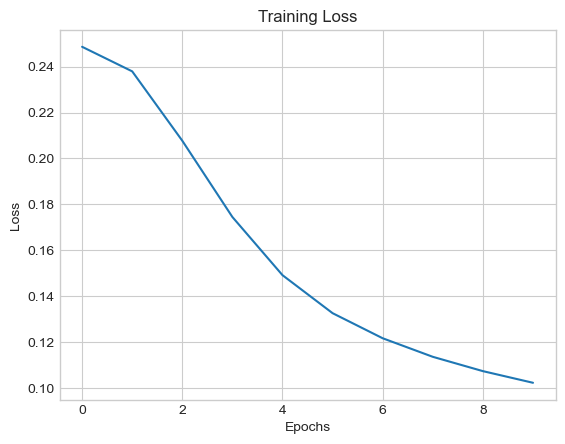

In [14]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# 加载数据
df = pd.read_csv('IMDB Dataset.csv')
print(df.head())

# 文本清洗
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['review'] = df['review'].apply(clean_text)

# 创建词汇表
def create_vocab(texts, vocab_size=10000):
    word_count = Counter(" ".join(texts).split())
    most_common = word_count.most_common(vocab_size)
    word_dict = {word: i+1 for i, (word, _) in enumerate(most_common)} 
    return word_dict

vocab = create_vocab(df['review'])
vocab_size = len(vocab) + 1  # 包括未知词

# 文本转换为数字
def text_to_sequence(texts, vocab):
    return [[vocab.get(word, 0) for word in text.split()] for text in texts]

X = text_to_sequence(df['review'], vocab)

# 标签转换为数字
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

class FastText:
    def __init__(self, vocab_size, embedding_dim):
        self.W1 = np.random.randn(vocab_size, embedding_dim) / np.sqrt(vocab_size)
        self.W2 = np.random.randn(embedding_dim, 1) / np.sqrt(embedding_dim)

    def forward(self, x):
        # 平均词向量
        self.embedding = np.mean(self.W1[x], axis=0)
        # 预测
        z = np.dot(self.embedding, self.W2)
        return 1 / (1 + np.exp(-z))  # sigmoid

    def backward(self, x, y, y_pred, lr):
        # 计算梯度
        dz = y_pred - y
        dW2 = np.outer(self.embedding, dz)
        dW1 = np.zeros_like(self.W1)
        for word in x:
            dW1[word] += dz * self.W2.flatten() / len(x)

        # 参数更新
        self.W1[x] -= lr * dW1[x]
        self.W2 -= lr * dW2
        return np.square(y_pred - y).mean()  # MSE loss

    def predict(self, x):
        y_pred = self.forward(x)
        return y_pred

def batch_generator(X, y, batch_size=32):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield [X[i] for i in excerpt], y[excerpt]

# 初始化模型
model = FastText(vocab_size, embedding_dim=50)
epochs = 10
learning_rate = 0.01
batch_size = 32

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, y_batch in batch_generator(X, y, batch_size):
        for x, y_true in zip(x_batch, y_batch):
            y_pred = model.forward(x)
            loss = model.backward(x, y_true, y_pred, learning_rate)
            epoch_loss += loss
    losses.append(epoch_loss / len(X))
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(X)}')
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()